## Converting the data set to format to be used as an input for a CNN

To convert chess board data into a format that can be used as an input for a CNN, the data is represented as an 8x8x12 binary matrix. Each slice along the third dimension presents the presence of a specific type of piece on the board. 

1. There are 12 possible piece types (6 types for each color: king, queen, rook, bishop, knight, pawn). We can assign each piece an index from 0 to 11. 

- White pieces: pawn, knight, rook, queen, king (0 - 5)
- Black pieces: pawn, knight, rook, queen, king (6 - 11)

2. Board Representation: 

- We will create an 8 x 8 x 12 matrix filled with zeros. 
For each square on the board, if a specific peice is present, set the corresponding position in the matrix to 1. 
- For example, if there's a white knight on e4, we will set the board[4][4][1] = 1 if the white knight has a corresponding index to 1. 


I am following the method used by the following author: https://erikbern.com/2014/11/29/deep-learning-for-chess.html


In [1]:
import numpy as np
import chess
import chess.pgn
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
from torch.utils.data import Dataset


In [2]:
spark = SparkSession.builder.appName("ChessGames").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/16 16:21:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/16 16:21:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
def board_to_tensor(board):
    
    # Initialize an 8x8x12 tensor of zeros
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    
    # Map piece types to the 3rd dimension indices in the tensor
    piece_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    
    # Iterate over all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)  # Convert square index to 2D coordinates
            color_offset = 0 if piece.color == chess.WHITE else 6  # 0-5 for white, 6-11 for black
            piece_index = piece_to_index[piece.piece_type] + color_offset
            board_tensor[row, col, piece_index] = 1
    
    return board_tensor

In [4]:
board = chess.Board()  # Starting position

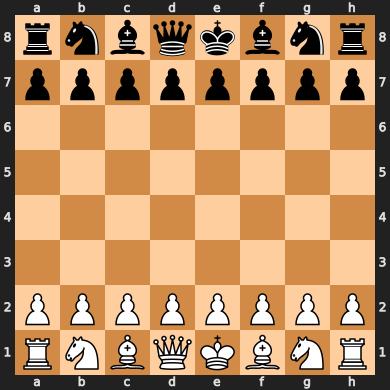

In [5]:
board

In [6]:
tensor = board_to_tensor(board)
tensor

array([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 



### Piece Index Mapping in the Tensor

Each index in the third dimension of the 8 x 8 x 12 tensor represents the presence of a specific piece type on the chessboard. 

The first two dimension (8 x 8): represent the rows and columns of the chessboard. 

The indices are as follows:

| Index | Piece           | Color  |
|-------|------------------|--------|
| 0     | Pawn            | White  |
| 1     | Knight          | White  |
| 2     | Bishop          | White  |
| 3     | Rook            | White  |
| 4     | Queen           | White  |
| 5     | King            | White  |
| 6     | Pawn            | Black  |
| 7     | Knight          | Black  |
| 8     | Bishop          | Black  |
| 9     | Rook            | Black  |
| 10    | Queen           | Black  |
| 11    | King            | Black  |

In this format, a value of `1` at a specific index in the tensor’s third dimension indicates the presence of the respective piece on that square of the chessboard. All other values are `0`, indicating the absence of that piece.

## Our data

In [7]:
file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    # Read the first game in the file
    game = chess.pgn.read_game(pgn_file)
    
    if game:
        # Print headers to confirm access
        print("First game headers:")
        for header, value in game.headers.items():
            print(f"{header}: {value}")
        
        # Initialize a board to track positions
        board = game.board()
        
        print("\nFirst game moves (LAN):")
        for i, move in enumerate(game.mainline_moves()):
            # Apply the move to the board
            board.push(move)
            # Print the move in LAN format
            print(move.uci(), end=" ")
            if i >= 10:  # Limit to the first 10 moves for brevity
                break
        print("\n...")

    else:
        print("No games found in the file or file is not accessible.")

First game headers:
Event: Rated Bullet game
Site: https://lichess.org/nQ1xYNSF
Date: 2024.08.01
Round: -
White: kingskreamer
Black: mysteryvabs
Result: 1-0
UTCDate: 2024.08.01
UTCTime: 00:00:09
WhiteElo: 2148
BlackElo: 2155
WhiteRatingDiff: +6
BlackRatingDiff: -6
ECO: B10
Opening: Caro-Kann Defense: Accelerated Panov Attack
TimeControl: 60+0
Termination: Time forfeit

First game moves (LAN):
e2e4 c7c6 c2c4 d7d5 c4d5 c6d5 e4d5 d8d5 b1c3 d5d8 f1c4 
...


To convert our games to a 8x8x12 matrix:
1. Initialize a starting board position
2. Apply each move to the board
3. After each move, convert the current board position into an 8 x 8 x 12 matrix

In [8]:
def board_to_tensor(board):
    
    # Initialize an 8x8x12 tensor of zeros
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    
    # Map piece types to the 3rd dimension indices in the tensor
    piece_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    
    # Iterate over all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)  # converting teh square index to 2D coordinates
            color_offset = 0 if piece.color == chess.WHITE else 6  # 0-5 for white, 6-11 for black
            piece_index = piece_to_index[piece.piece_type] + color_offset
            board_tensor[row, col, piece_index] = 1
    
    return board_tensor

In [9]:
games_data = []

# Read and process each game in the PGN file
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    while True:
        # Read the next game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break  # End of file

        # List to hold the matrix for each move in the game
        game_matrices = []

        # Initialize the board for the game and apply moves
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            # Convert the board to an 8x8x12 tensor and add to the game_matrices
            game_matrices.append(board_to_tensor(board))

        # Add the entire game (sequence of board positions) to the games_data list
        games_data.append(np.array(game_matrices))

In [10]:
def extract_piece_positions(board):
    """
    Extracts piece positions from the board in a human-readable format (e.g., White_Knight at b1).
    """
    piece_positions = {}
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_name = f"{'White' if piece.color else 'Black'}_{piece.symbol().upper()}"
            piece_positions[piece_name] = chess.square_name(square)
    return piece_positions

In [11]:
# Open the PGN file and process the first game
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    game = chess.pgn.read_game(pgn_file)  # Read the first game
    if game:
        # Initialize the board
        board = game.board()

        # Process each move
        for move_number, move in enumerate(game.mainline_moves()):
            # Push the move to update the board
            board.push(move)

            # Extract piece positions
            piece_positions = {
                "Move": move_number,
                "Next_Move": move.uci() if move_number < len(list(game.mainline_moves())) - 1 else None
            }
            for square in chess.SQUARES:
                piece = board.piece_at(square)
                if piece:
                    piece_name = f"{'White' if piece.color else 'Black'}_{piece.symbol().upper()}"
                    piece_positions[piece_name] = chess.square_name(square)

            # Append the piece positions to the game data
            game_data.append(piece_positions)

        # Convert the game data to a DataFrame for inspection
        df_first_game = pd.DataFrame(game_data)
        print(df_first_game.head())
    else:
        print("No games found in the file or file is not accessible.")

NameError: name 'game_data' is not defined

In [12]:
import chess.pgn
import pandas as pd

file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'

# Open the PGN file and extract the first game
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    game = chess.pgn.read_game(pgn_file)

if game:
    # Initialize the board and data structure
    board = game.board()
    game_data = []  # To store the state of the board after each move

    # Process one move at a time for Game 1
    for move_number, move in enumerate(game.mainline_moves()):
        print(f"Processing Move {move_number}: {move.uci()}")

        # Capture piece positions BEFORE the move
        piece_positions = {"Move": move_number}

        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                piece_name = f"{'White' if piece.color else 'Black'}_{piece.symbol().upper()}"
                piece_positions[piece_name] = chess.square_name(square)

        # Add next move information
        piece_positions["Next_Move"] = move.uci()

        # Save the positions for the current move
        game_data.append(piece_positions)

        # Push the move to the board
        board.push(move)

        # Display the board and state
        print(board)
        print(piece_positions)

        # Ask if user wants to process the next move
        user_input = input("Process next move? (y/n): ").strip().lower()
        if user_input != 'y':
            break  # Stop processing further moves

    # Convert game_data to a DataFrame
    df_game1 = pd.DataFrame(game_data)
    print("\nDataFrame for Game 1:")
    print(df_game1.head())
else:
    print("No games found in the file or file is not accessible.")


Processing Move 0: e2e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
{'Move': 0, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'h2', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'e2e4'}


Process next move? (y/n):  y


Processing Move 1: c7c6
r n b q k b n r
p p . p p p p p
. . p . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
{'Move': 1, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'e4', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'c7c6'}


Process next move? (y/n):  y


Processing Move 2: c2c4
r n b q k b n r
p p . p p p p p
. . p . . . . .
. . . . . . . .
. . P . P . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 2, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'e4', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'c2c4'}


Process next move? (y/n):  y


Processing Move 3: d7d5
r n b q k b n r
p p . . p p p p
. . p . . . . .
. . . p . . . .
. . P . P . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 3, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'e4', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'd7d5'}


Process next move? (y/n):  y


Processing Move 4: c4d5
r n b q k b n r
p p . . p p p p
. . p . . . . .
. . . P . . . .
. . . . P . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 4, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'e4', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'c4d5'}


Process next move? (y/n):  y


Processing Move 5: c6d5
r n b q k b n r
p p . . p p p p
. . . . . . . .
. . . p . . . .
. . . . P . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 5, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'd5', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'c6d5'}


Process next move? (y/n):  y


Processing Move 6: e4d5
r n b q k b n r
p p . . p p p p
. . . . . . . .
. . . P . . . .
. . . . . . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 6, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'e4', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'e4d5'}


Process next move? (y/n):  y


Processing Move 7: d8d5
r n b . k b n r
p p . . p p p p
. . . . . . . .
. . . q . . . .
. . . . . . . .
. . . . . . . .
P P . P . P P P
R N B Q K B N R
{'Move': 7, 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'd5', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8', 'Next_Move': 'd8d5'}


Process next move? (y/n):  yy



DataFrame for Game 1:
   Move White_R White_N White_B White_Q White_K White_P Black_P Black_R  \
0     0      h1      g1      f1      d1      e1      h2      h7      h8   
1     1      h1      g1      f1      d1      e1      e4      h7      h8   
2     2      h1      g1      f1      d1      e1      e4      h7      h8   
3     3      h1      g1      f1      d1      e1      e4      h7      h8   
4     4      h1      g1      f1      d1      e1      e4      h7      h8   

  Black_N Black_B Black_Q Black_K Next_Move  
0      g8      f8      d8      e8      e2e4  
1      g8      f8      d8      e8      c7c6  
2      g8      f8      d8      e8      c2c4  
3      g8      f8      d8      e8      d7d5  
4      g8      f8      d8      e8      c4d5  


In [25]:
import chess.pgn
import pandas as pd

file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'

# Open the PGN file and extract the first game
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    game = chess.pgn.read_game(pgn_file)

if game:
    # Initialize the board and data structure
    board = game.board()
    game_data = []  # To store the state of the board after each move

    # Process each move for Game 1
    for move_number, move in enumerate(game.mainline_moves()):
        print(f"Processing Move {move_number}: {move.uci()}")

        # Capture piece positions AFTER the move
        piece_positions = {"Move": move_number, "Next_Move": move.uci()}

        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                piece_name = f"{'White' if piece.color else 'Black'}_{piece.symbol().upper()}"
                piece_positions[piece_name] = chess.square_name(square)

        # Save the current state before pushing the move
        game_data.append(piece_positions)

        # Push the move to the board
        board.push(move)

        # Display the board and state for debugging
        print(board)
        print(piece_positions)

        # Ask if user wants to process the next move
        user_input = input("Process next move? (y/n): ").strip().lower()
        if user_input != 'y':
            break

    # Convert game_data to a DataFrame
    df_game1 = pd.DataFrame(game_data)
    print("\nDataFrame for Game 1:")
    print(df_game1.head())
else:
    print("No games found in the file or file is not accessible.")


Processing Move 0: e2e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
{'Move': 0, 'Next_Move': 'e2e4', 'White_R': 'h1', 'White_N': 'g1', 'White_B': 'f1', 'White_Q': 'd1', 'White_K': 'e1', 'White_P': 'h2', 'Black_P': 'h7', 'Black_R': 'h8', 'Black_N': 'g8', 'Black_B': 'f8', 'Black_Q': 'd8', 'Black_K': 'e8'}


KeyboardInterrupt: Interrupted by user

In [26]:
file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'

# Open the PGN file and extract the first game
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    game = chess.pgn.read_game(pgn_file)

if game:
    # Initialize the board and data structure
    board = game.board()
    game_data = []  # To store the state of the board after each move

    # Process each move for Game 1
    for move_number, move in enumerate(game.mainline_moves()):
        print(f"Processing Move {move_number}: {move.uci()}")

        # Capture piece positions AFTER the move
        piece_positions = {"Move": move_number, "Next_Move": move.uci()}

        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                piece_name = f"{'White' if piece.color else 'Black'}_{piece.symbol().upper()}"
                piece_positions[piece_name] = chess.square_name(square)

        # Append the dictionary to the game_data list
        game_data.append(piece_positions)

        # Push the move to the board
        board.push(move)

    # Display extracted dictionaries
    for move_data in game_data:
        print(move_data)  # Print each move's dictionary
else:
    print("No games found in the file or file is not accessible.")

Processing Move 0: e2e4
Processing Move 1: c7c6
Processing Move 2: c2c4
Processing Move 3: d7d5
Processing Move 4: c4d5
Processing Move 5: c6d5
Processing Move 6: e4d5
Processing Move 7: d8d5
Processing Move 8: b1c3
Processing Move 9: d5d8
Processing Move 10: f1c4
Processing Move 11: g8f6
Processing Move 12: d1b3
Processing Move 13: e7e6
Processing Move 14: g1f3
Processing Move 15: b8c6
Processing Move 16: c4b5
Processing Move 17: c8d7
Processing Move 18: e1g1
Processing Move 19: a8c8
Processing Move 20: f1e1
Processing Move 21: a7a6
Processing Move 22: b5a4
Processing Move 23: b7b5
Processing Move 24: c3b5
Processing Move 25: a6b5
Processing Move 26: a4b5
Processing Move 27: f8e7
Processing Move 28: f3e5
Processing Move 29: e8g8
Processing Move 30: e5d7
Processing Move 31: d8d7
Processing Move 32: b3f3
Processing Move 33: d7c7
Processing Move 34: b5e2
Processing Move 35: c6e5
Processing Move 36: f3g3
Processing Move 37: e5g6
Processing Move 38: f2f4
Processing Move 39: c7f4
Processing

In [27]:
game_data

[{'Move': 0,
  'Next_Move': 'e2e4',
  'White_R': 'h1',
  'White_N': 'g1',
  'White_B': 'f1',
  'White_Q': 'd1',
  'White_K': 'e1',
  'White_P': 'h2',
  'Black_P': 'h7',
  'Black_R': 'h8',
  'Black_N': 'g8',
  'Black_B': 'f8',
  'Black_Q': 'd8',
  'Black_K': 'e8'},
 {'Move': 1,
  'Next_Move': 'c7c6',
  'White_R': 'h1',
  'White_N': 'g1',
  'White_B': 'f1',
  'White_Q': 'd1',
  'White_K': 'e1',
  'White_P': 'e4',
  'Black_P': 'h7',
  'Black_R': 'h8',
  'Black_N': 'g8',
  'Black_B': 'f8',
  'Black_Q': 'd8',
  'Black_K': 'e8'},
 {'Move': 2,
  'Next_Move': 'c2c4',
  'White_R': 'h1',
  'White_N': 'g1',
  'White_B': 'f1',
  'White_Q': 'd1',
  'White_K': 'e1',
  'White_P': 'e4',
  'Black_P': 'h7',
  'Black_R': 'h8',
  'Black_N': 'g8',
  'Black_B': 'f8',
  'Black_Q': 'd8',
  'Black_K': 'e8'},
 {'Move': 3,
  'Next_Move': 'd7d5',
  'White_R': 'h1',
  'White_N': 'g1',
  'White_B': 'f1',
  'White_Q': 'd1',
  'White_K': 'e1',
  'White_P': 'e4',
  'Black_P': 'h7',
  'Black_R': 'h8',
  'Black_N': 'g8'